In [6]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
from bm3d import bm3d_rgb, BM3DProfile
import sys
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import math
import torch
import torch.nn as nn
import torch.optim as optim
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

module_dir_scu = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet" 
sys.path.insert(0, module_dir_scu)
from models.network_scunet import SCUNet as SCUNet
from torch.utils.data import Dataset
from utils import utils_image as util
import joblib
from sklearn.preprocessing import MinMaxScaler

/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:

with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    ref_d = file['density'][:]

In [8]:
#### test file #######
with h5py.File('/pscratch/sd/k/kberard/SCGSR/Data/diamond_1x1x1_bfd/density_data/vmc_J2/density_tot_vmc_mean_0000655360.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    test_d = file['density'][:]

In [9]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)

In [10]:
def encode_voxel_to_rgb(test_d, save_path='slice_scalers.npz'):
    """
    Normalize each XY slice independently and encode to RGB (repeated channels).
    Saves (min, max) for each slice for reconstruction.
    
    Returns:
        rgb_volume: (64, 64, 64, 3)
    """
    rgb_volume = np.zeros((64, 64, 64, 3), dtype=np.float32)
    mins = []
    maxs = []

    for i in range(64):
        slice_2d = test_d[i, :, :]
        s_min = float(slice_2d.min())
        s_max = float(slice_2d.max())

        if s_max == s_min:
            s_max = s_min + 1e-6  # Avoid divide-by-zero for flat slices

        normed = (slice_2d - s_min) / (s_max - s_min)
        rgb_volume[i, :, :, :] = np.stack([normed]*3, axis=-1)  # (64, 64, 3)

        mins.append(s_min)
        maxs.append(s_max)

    np.savez(save_path, mins=np.array(mins), maxs=np.array(maxs))
    return rgb_volume  # shape: (64, 64, 64, 3)


In [11]:
def decode_rgb_to_voxel(rgb_volume, save_path='slice_scalers.npz'):
    """
    Decode per-slice normalized RGB volume back into scalar 3D volume.
    Assumes all RGB channels are identical.
    
    Args:
        rgb_volume: shape (64, 64, 64, 3)
    """
    data = np.load(save_path)
    mins = data['mins']
    maxs = data['maxs']

    test_d = np.zeros((64, 64, 64), dtype=np.float32)

    for i in range(64):
        rgb_slice = rgb_volume[i]  # (64, 64, 3)
        gray = rgb_slice[:, :, 0]
        restored = gray * (maxs[i] - mins[i]) + mins[i]
        test_d[i] = restored

    return test_d


In [13]:
############### scunet_Pretrained ###############

def scunet_pre_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    # Load pretrained model
    model = SCUNet(in_nc=3, config=[4, 4, 4, 4, 4, 4, 4], dim=64)
    model_path = '/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet/model_zoo/scunet_color_25.pth'  # Adjust if needed
    model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=True)
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Args:
            rgb_image_np: (H, W, 3), float32 or float64, values in [0,1]
            model: SCUNet model
            device: 'cuda' or 'cpu'
        
        Returns:
            Denoised image (H, W, 3), uint8
        """
        # Make sure image is float32 in [0,1]
        img = rgb_image_np.astype(np.float32)
        img_tensor = util.single2tensor4(img).to(device)
        with torch.no_grad():
            output_tensor = model(img_tensor)
        output_np = util.tensor2single(output_tensor)
        return np.clip(output_np.transpose(1, 2, 0), 0, 1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    

    for i in range(test_rgb.shape[0]):
        
        noisy_slice = test_rgb[i]

        #gray_input = noisy_slice[:, :, 0]  # just one channel
        #denoised_gray = bm3d(gray_input, sigma_psd=sigma)
        #denoised_rgb[i] = np.stack([denoised_gray] * 3, axis=-1)
        denoise =denoise_with_scunet(noisy_slice, model, device=device)
        denoised_rgb[i] = np.transpose(denoise, (0,2,1))
        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

I0000 00:00:1753989569.416108 1993585 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1753989569.419013 1993585 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1753989569.420566 1993585 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1753989569.421915 1993585 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0047
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.004060


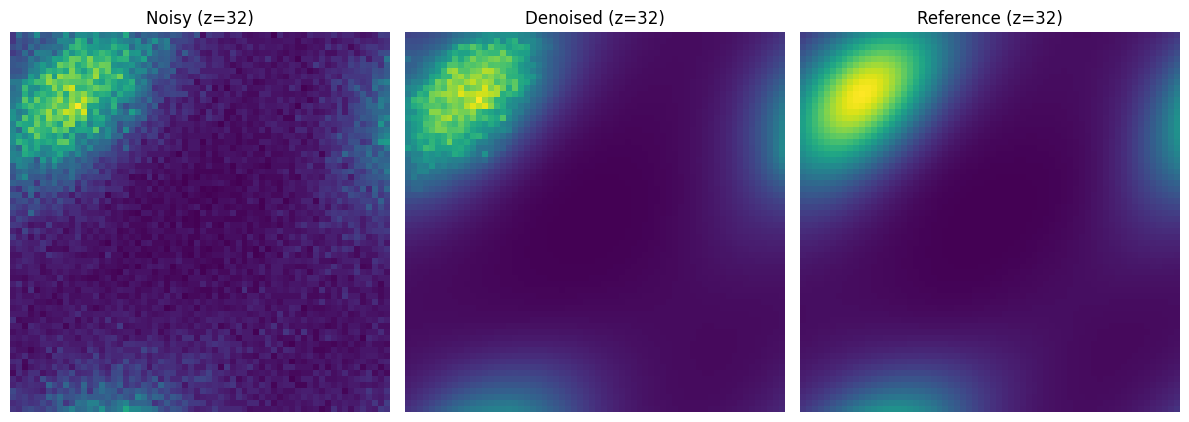

In [14]:
# Simulated test
np.random.seed(42)
scunet_pre_test_pipeline(test_d, ref_d)


In [13]:
############### scunet_Trained ###############

def scunet_trained_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    
    torch.serialization.add_safe_globals([SCUNet])

    model = torch.load('scunet_trained', weights_only=False)
    model.eval()
    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Args:
            rgb_image_np: (H, W, 3), float32 or float64, values in [0,1]
            model: SCUNet model
            device: 'cuda' or 'cpu'
        
        Returns:
            Denoised image (H, W, 3), uint8
        """
        # Make sure image is float32 in [0,1]
        img = rgb_image_np.astype(np.float32)
        img_tensor = util.single2tensor4(img).to(device)
        with torch.no_grad():
            output_tensor = model(img_tensor)
        output_np = util.tensor2single(output_tensor)
        return output_np
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    


    
    for i in range(test_rgb.shape[0]):
        noisy_slice = test_rgb[i]  # shape: (H, W, 3), values in [0, 1]
        denoised = denoise_with_scunet(noisy_slice, model, device=device)  # (3, H, W)
        
        # Transpose from (C, H, W) -> (H, W, C)
        denoised_rgb[i] = denoised


        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [15]:
############### scunet_Trained ###############

def scunet_trained_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    
    torch.serialization.add_safe_globals([SCUNet])

    model = torch.load('scunet_trained', weights_only=False)
    model.eval()
    def single2tensor4(img):
        """
        Convert HWC image [0,1] float32 to NCHW tensor
        """
        img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0)  # shape (1, 3, H, W)
        return img_tensor
    def tensor2single(tensor):
        """
        Convert NCHW or CHW tensor to HWC numpy array, clipped to [0,1]
        """
        tensor = tensor.squeeze().cpu().detach().numpy()
        if tensor.ndim == 3:
            img_np = np.transpose(tensor, (1, 2, 0))  # CHW -> HWC
        else:
            img_np = tensor  # in case it's grayscale
        return np.clip(img_np, 0, 1)


    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Denoise a single RGB image using SCUNet.
    
        Args:
            rgb_image_np: (H, W, 3), float32, values in [0,1]
            model: PyTorch SCUNet model
            device: 'cuda' or 'cpu'
    
        Returns:
            Denoised image (H, W, 3), float32 in [0,1]
        """
        img = rgb_image_np.astype(np.float32)
        
        # Ensure range is [0, 1]
        img = np.clip(img, 0, 1)
    
        img_tensor = single2tensor4(img).to(device)
    
        with torch.no_grad():
            output_tensor = model(img_tensor)
    
        output_np = tensor2single(output_tensor)
        return output_np

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    


    
    for i in range(test_rgb.shape[0]):
        noisy_slice = test_rgb[i]  # shape: (H, W, 3)
    
        denoised = denoise_with_scunet(noisy_slice, model, device=device)  # shape: (H, W, 3)
    
        if np.isnan(denoised).any():
            print(f"⚠️ NaNs detected in denoised slice {i}")
    
        denoised_rgb[i] = denoised



        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0087
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.013617


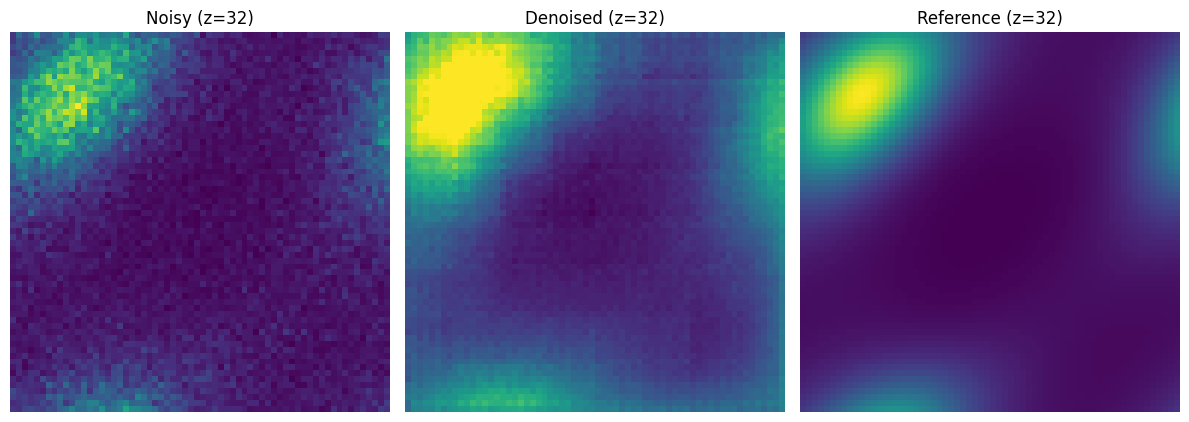

In [16]:

scunet_trained_test_pipeline(test_d, ref_d)

In [17]:
############## scunet_TL ##################

def scunet_FT_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    
    torch.serialization.add_safe_globals([SCUNet])

    model = torch.load('scunet_finetuned', weights_only=False)
    model.eval()
    def single2tensor4(img):
        """
        Convert HWC image [0,1] float32 to NCHW tensor
        """
        img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0)  # shape (1, 3, H, W)
        return img_tensor
    def tensor2single(tensor):
        """
        Convert NCHW or CHW tensor to HWC numpy array, clipped to [0,1]
        """
        tensor = tensor.squeeze().cpu().detach().numpy()
        if tensor.ndim == 3:
            img_np = np.transpose(tensor, (1, 2, 0))  # CHW -> HWC
        else:
            img_np = tensor  # in case it's grayscale
        return np.clip(img_np, 0, 1)


    def denoise_with_scunet(rgb_image_np, model, device='cuda'):
        """
        Denoise a single RGB image using SCUNet.
    
        Args:
            rgb_image_np: (H, W, 3), float32, values in [0,1]
            model: PyTorch SCUNet model
            device: 'cuda' or 'cpu'
    
        Returns:
            Denoised image (H, W, 3), float32 in [0,1]
        """
        img = rgb_image_np.astype(np.float32)
        
        # Ensure range is [0, 1]
        img = np.clip(img, 0, 1)
    
        img_tensor = single2tensor4(img).to(device)
    
        with torch.no_grad():
            output_tensor = model(img_tensor)
    
        output_np = tensor2single(output_tensor)
        return output_np

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    


    
    for i in range(test_rgb.shape[0]):
        noisy_slice = test_rgb[i]  # shape: (H, W, 3)
    
        denoised = denoise_with_scunet(noisy_slice, model, device=device)  # shape: (H, W, 3)
    
        if np.isnan(denoised).any():
            print(f"⚠️ NaNs detected in denoised slice {i}")
    
        denoised_rgb[i] = denoised



        

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0039
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.010247


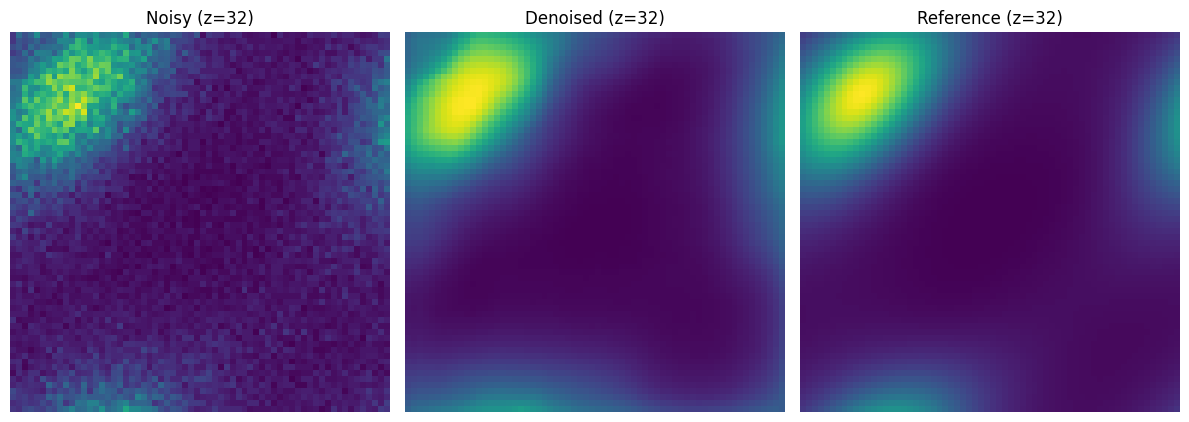

In [18]:

scunet_FT_test_pipeline(test_d, ref_d)

In [10]:
from keras.models import load_model
import keras

############# Nature #####################
import tensorflow as tf
@tf.keras.utils.register_keras_serializable()
class OnesLikeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.ones_like(inputs)
def ones_like_fn(a):
    return tf.ones_like(a)
# Now load the model
nature_mod = tf.keras.models.load_model(
    "Nature.keras",
    custom_objects={'ones_like_fn': ones_like_fn}
)

from keras.layers import Lambda

layer = Lambda(lambda x: x, output_shape=(64, 64, 3))
def Nature_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)
    print(test_rgb.shape,"x_test_shape")

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    
    #denoised_rgb = nature_mod.predict(noisy_slice)  # shape: (H, W, 3)
    



    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")
    print(denoised_d.shape)

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


I0000 00:00:1754058287.561078 1602639 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1754058287.563147 1602639 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1754058287.565834 1602639 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1754058287.569012 1602639 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


(64, 64, 64, 3) x_test_shape

>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0193
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.080567
(64, 64, 64)


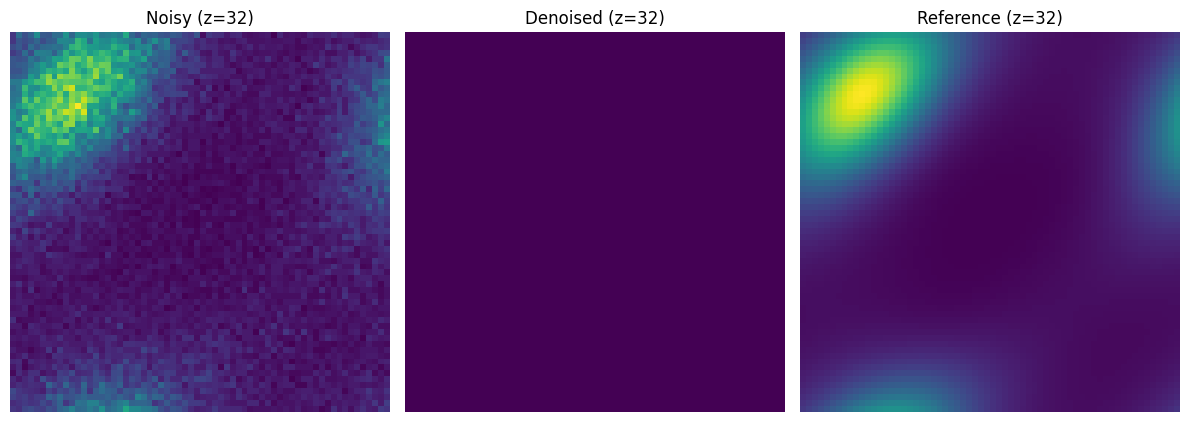

In [11]:

Nature_test_pipeline(test_d, ref_d)

In [18]:
############### CAE_img_enc ###############
from keras.models import load_model
import keras
keras.config.enable_unsafe_deserialization()
CAE_mod = load_model('CAE.keras')
from keras.layers import Lambda

def CAE_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    
    denoised_rgb = CAE_mod.predict(test_rgb)  # shape: (H, W, 3)
    



    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


I0000 00:00:1754057713.315662 1582385 service.cc:152] XLA service 0x7fd678008300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754057713.315690 1582385 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754057713.315694 1582385 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754057713.315697 1582385 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754057713.315699 1582385 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-01 07:15:13.332626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754057713.399039 1582385 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step 


I0000 00:00:1754057714.079932 1582385 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0099
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.028903


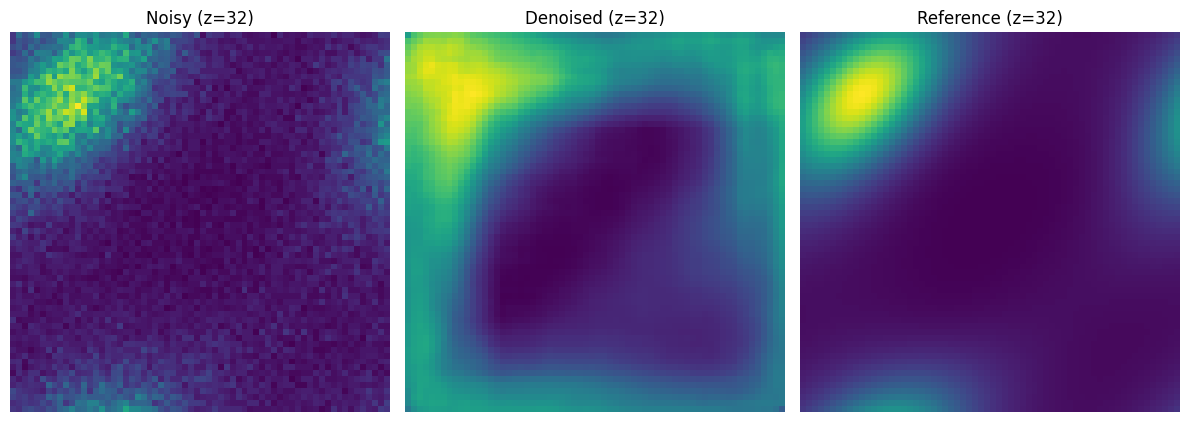

In [19]:

CAE_test_pipeline(test_d, ref_d)

In [12]:
# Fully working 

################# CAE_full_3D #############
from keras.models import load_model
import keras

############# Nature #####################
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class RenormalizeToEight(tf.keras.layers.Layer):
    def call(self, x):
        total = tf.reduce_sum(x, axis=[1, 2, 3, 4], keepdims=True)
        return x / (total + 1e-8) * 8.0

@tf.keras.utils.register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# === Custom Loss ===
@keras.saving.register_keras_serializable()
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )


from keras.models import load_model
import keras

CAE_3D_mod = tf.keras.models.load_model(
    "CAE_3D.keras",
    custom_objects={
        "RenormalizeToEight": RenormalizeToEight,
        "jensen_shannon_divergence_loss": jensen_shannon_divergence_loss
    }
)
from keras.layers import Lambda

def CAE_3D_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = test_d
    ref_rgb  = ref_d
    reshaped_arr = test_rgb.reshape(1, 64, 64, 64, 1)
    
    denoised_rgb = CAE_3D_mod.predict(reshaped_arr)  # shape: (H, W, 3)
    



    # Reconstruct full 3D volume
    denoised_d = denoised_rgb.reshape(64,64,64)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    print(test_d.shape,denoised_d.shape,ref_d.shape)

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


I0000 00:00:1754063528.213955 1642122 service.cc:152] XLA service 0x7fcaf0008aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754063528.213997 1642122 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754063528.214002 1642122 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754063528.214005 1642122 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754063528.214023 1642122 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-01 08:52:08.238935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754063528.307961 1642122 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1754063529.661595 1642122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0003
JSD   (noisy vs ref):     0.000013
JSD   (denoised vs ref):  0.000000
(64, 64, 64) (64, 64, 64) (64, 64, 64)


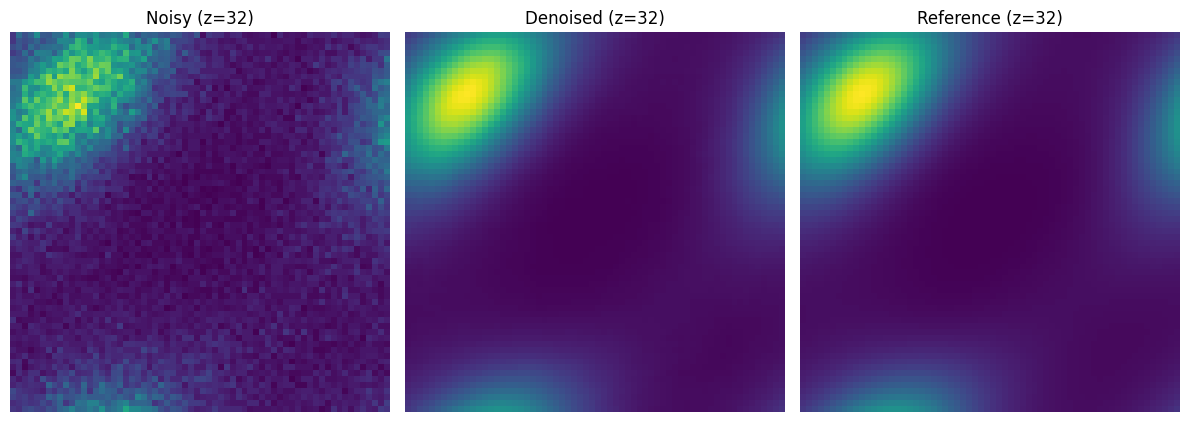

In [13]:

CAE_3D_test_pipeline(test_d, ref_d)

In [16]:
from bm3d import bm3d
def bm3d_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    N = 100
    sigma = np.sqrt(1.0 / N)
    print("here")
    print(test_rgb.shape)



    #######
    for i in range(64):
        noisy_slice = test_rgb[i]

        gray_input = noisy_slice[:, :, 0]  # just one channel
        denoised_gray = bm3d(gray_input, sigma_psd=sigma)
        denoised_rgb[i] = np.stack([denoised_gray] * 3, axis=-1)

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

here
(64, 64, 64, 3)

>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0045
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.003858


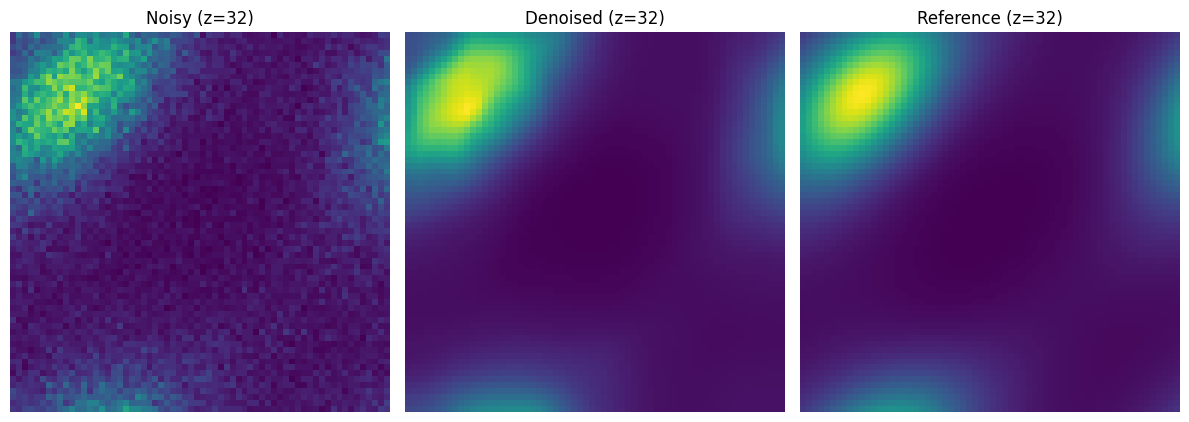

In [17]:
# Simulated test
np.random.seed(42)
bm3d_test_pipeline(test_d, ref_d)
